In this blog post, I am going to go through as series of neural network structures.
This is intended as a demonstration of the more basic neural net functionality.
This blog post serves as an accompanyment to the introduction to machine learning chapter of the short book I am writing (
Currently under the working title "Neural Network Representations for Natural Language Processing")
<!-- more -->

I do have an [earlier blog covering some similar topics](http://white.ucc.asn.au/2017/01/24/JuliaML-and-TensorFlow-Tuitorial.html).
However, I exect the code in this one to be a lot more sensible,
since I am now much more familar with TensorFlow.jl, having now written a significant chunk of it.
Also MLDataUtils.jl is in different state to what it was.


In [1]:
using TensorFlow
using MLDataUtils
using MLDatasets

using ProgressMeter

using Base.Test
using Plots
gr()
using FileIO
using ImageCore

# MNIST classifier

This is the most common benchmark for neural network classifiers.
[MNIST](http://yann.lecun.com/exdb/mnist/) is a collection of hand written digits from 0 to 9.
The task is to determine which digit is being shown.
With neural networks this is done by flattening the images into vectors, 
and using one-hot encoded outputs with softmax.

In [2]:
"""Makes 1 hot, row encoded labels."""
onehot_encode_labels(labels_raw) = convertlabel(LabelEnc.OneOfK, labels_raw, LabelEnc.NativeLabels(collect(0:9)),  LearnBase.ObsDim.First())
"""Convert 3D matrix of row,column,observation to vector,observation"""
flatten_images(img_raw) = squeeze(mapslices(vec, img_raw,1:2),2)




@testset "data prep" begin
    @test onehot_encode_labels([4,1,2,3,0]) == [0 0 0 0 1 0 0 0 0 0
                                  0 1 0 0 0 0 0 0 0 0
                                  0 0 1 0 0 0 0 0 0 0
                                  0 0 0 1 0 0 0 0 0 0
                                  1 0 0 0 0 0 0 0 0 0]
    
    data_b1 = flatten_images(MNIST.traintensor())
    @test size(data_b1) == (28*28, 60_000)
    labels_b1 = onehot_encode_labels(MNIST.trainlabels())
    @test size(labels_b1) == (60_000, 10)
end;

Test Summary: | Pass  Total
data prep     |    3      3


A visualisation of one of the examples from MNIST.
Code is a little complex because of the unflattening, and adding a border.

In [3]:
const frames_image_res = 30

"Convests a image vector into a framed 2D image"
function one_image(img::Vector)
    ret = zeros((frames_image_res, frames_image_res))
    ret[2:end-1, 2:end-1] = 1-rotl90(reshape(img, (28,28)))
    ret
end

train_images=flatten_images(MNIST.traintensor())
heatmap(one_image(train_images[:,10]))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
<image width="493" height="361" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAAe0AAAFpCAYAAACxlXA1AAAJ6UlEQVR4nO3cX6jfdR3H8c/3nN9i
O65M+ycN3NSSaliuOANdYjWokKaCUoZxONI6XmSpEIQgdLMK7EaSKFfmdJnOQdYs5jLzQlsk9Gel
ZiSxMiocbW3Os+YO59dFV6Og8P07/H6vH4/H/fvNmwPb8/e5+Xat9foNABh5E8M+AAD4/4g2AIQQ
bQAIIdoAEEK0ASCEaANACNEGgBCiDQAhRBsAQog2AIQQbQAIIdoAEKI3iCUL/W2DWAMAY63XzZbm
vbQBIIRoA0AI0QaAEKINACFEGwBCiDYAhBBtAAgh2gAQQrQBIIRoA0AI0QaAEKINACFEGwBCiDYA
hBBtAAgh2gAQQrQBIIRoA0AI0QaAEKINACFEGwBCiDYAhBBtAAgh2gAQQrQBIIRoA0AI0QaAEKIN
ACFEGwBCiDYAhBBtAAgh2gAQQrQBIIRoA0AI0QaAEKINACFEGwBCiDYAhBBtAAgh2gAQQrQBIIRo
A0AI0QaAEKINACFEGwBCiDYAhBBtAAjRG/YBACytmdOfKO/oF+e3H1xfvgEvbQCIIdoAEEK0ASCE
aANACNEGgBCiDQAhRBsAQog2AIQQbQAIIdoAEEK0ASCEb48DjLh7z3ukNH//kV3lG24958ryDuq8
tAEghGgDQAjRBoAQog0AIUQbAEKINgCEEG0ACCHaABBCtAEghGgDQAjRBoAQvj0OsMR2rXuoNH/N
b3eX5pdNnlKab621q977aHHDReUb8NIGgBiiDQAhRBsAQog2AIQQbQAIIdoAEEK0ASCEaANACNEG
gBCiDQAhRBsAQvj2OMASu2//aaX5xcX50vyVp15dmm+ttVd/bX15B3Ve2gAQQrQBIIRoA0AI0QaA
EKINACFEGwBCiDYAhBBtAAgh2gAQQrQBIIRoA0AI3x6HJbB46+byjrktc6X52/YdLM2vWPXB0vy4
OLj5C+Ude47X3kdvndpUmr9z6/bS/L/59vgo8NIGgBCiDQAhRBsAQog2AIQQbQAIIdoAEEK0ASCE
aANACNEGgBCiDQAhRBsAQvj2OCyBd918eXnHk/O3l+a3PtDVDrjOt8dba+2Se6fLOw4fu6c0/8cb
jtYOuOK22jwjw0sbAEKINgCEEG0ACCHaABBCtAEghGgDQAjRBoAQog0AIUQbAEKINgCEEG0ACOHb
47AETu+/sryjK/6mXnzhFaX5sflFv/O60vhTC68qn9B1k6X5l16YKt/AeBibf5cAMO5EGwBCiDYA
hBBtAAgh2gAQQrQBIIRoA0AI0QaAEKINACFEGwBCiDYAhPDtcfgvfjj9/dL8Y/98sHzDO1d8uDS/
8NGjpflR+M9h/vCT5R1f+szHSvPHT9xRvmHTys2l+ZVfObd8A+PBSxsAQog2AIQQbQAIIdoAEEK0
ASCEaANACNEGgBCiDQAhRBsAQog2AIQQbQAIMQqfF4aBOrHvq+UdM08fL81PdMvLN/xky87S/OSa
reUbhu3u9YfKOz7/3N2l+TeeckH5hu8cqe+A1ry0ASCGaANACNEGgBCiDQAhRBsAQog2AIQQbQAI
IdoAEEK0ASCEaANACNEGgBC+Pc7o+d6NpfF1V19UPuHgsd2l+bvWXlW+YfLGjeUdw/bL991Tmr/+
2b0DuuTle3Rj7Tv0MEhe2gAQQrQBIIRoA0AI0QaAEKINACFEGwBCiDYAhBBtAAgh2gAQQrQBIIRo
A0AI3x7nJAsnDpfmD8x8s3zDmTuOlOb7/V3lG7pusjT/7f0ryjeseffO0vy6hy8szU/86cel+dZa
u/mJc4obHi/fcMvZs6X5s767oXwDDIqXNgCEEG0ACCHaABBCtAEghGgDQAjRBoAQog0AIUQbAEKI
NgCEEG0ACCHaABDCt8c5yaHNt5fmV+/4ffmGrvpbsiuf0N42dVlpfs+Ld5Zv2LO3Nv+B168qze9r
x2sHtNb+Nl/7O7xm6u3lG2541rfDGR9e2gAQQrQBIIRoA0AI0QaAEKINACFEGwBCiDYAhBBtAAgh
2gAQQrQBIIRoA0CIrrVev7pkob9tAKcwCIeu3VKaf8M3nivNT3TLS/OttXba8jeV5v/8uafKN0yu
qX2Wf+bamfIN9/3j6+UdFf22WN5R/458/V1xxtR0aX7/QwfKN0xsuKm8g/HQ62ZL817aABBCtAEg
hGgDQAjRBoAQog0AIUQbAEKINgCEEG0ACCHaABBCtAEghGgDQIjaB5YZOZ/e+f7S/NlT+0vzj1zy
19J8a62t2vGp8o5hu2vlZ8s75j/y8dL8rqN3lG8Yun79++effN3a0vzEhgvKN8CgeGkDQAjRBoAQ
og0AIUQbAEKINgCEEG0ACCHaABBCtAEghGgDQAjRBoAQog0AIXx7fMzcNP10af7NtxwrzS97x/Wl
+XHR/93fyzt+9NKeAVzy8h2YW13eceplLw7gkppj092wT4CB8dIGgBCiDQAhRBsAQog2AIQQbQAI
IdoAEEK0ASCEaANACNEGgBCiDQAhRBsAQnSt9frVJQv9bQM4BUbH/POPl+bvf89C+YZPPLO9NP+W
qU2l+d8cvbw0D/ynXjdbmvfSBoAQog0AIUQbAEKINgCEEG0ACCHaABBCtAEghGgDQAjRBoAQog0A
IUQbAEL0hn0AjKJfX/GX0vzcMw+Xb3jt1Pml+V/89PnyDcBo8dIGgBCiDQAhRBsAQog2AIQQbQAI
IdoAEEK0ASCEaANACNEGgBCiDQAhRBsAQvj2OGNn4edfLu+Y/dUZtQVd/ffwt9auLs0vO+/S8g3A
aPHSBoAQog0AIUQbAEKINgCEEG0ACCHaABBCtAEghGgDQAjRBoAQog0AIUQbAEL49jhjZ93FZ5Z3
/GH+B6X5L551TfmGjT+7sLwDGC9e2gAQQrQBIIRoA0AI0QaAEKINACFEGwBCiDYAhBBtAAgh2gAQ
QrQBIIRoA0AI3x5n7Gw9/0R5x8V7a/NzH9pdvqE13x4HTualDQAhRBsAQog2AIQQbQAIIdoAEEK0
ASCEaANACNEGgBCiDQAhRBsAQog2AIToWuv1q0sW+tsGcAoAjLdeN1ua99IGgBCiDQAhRBsAQog2
AIQQbQAIIdoAEEK0ASCEaANACNEGgBCiDQAhRBsAQog2AIQQbQAIIdoAEEK0ASCEaANACNEGgBCi
DQAhRBsAQog2AIQQbQAIIdoAEEK0ASCEaANACNEGgBCiDQAhRBsAQog2AIQQbQAIIdoAEEK0ASCE
aANACNEGgBCiDQAhRBsAQog2AIQQbQAIIdoAEEK0ASCEaANACNEGgBCiDQAhRBsAQog2AIQQbQAI
IdoAEEK0ASBE11qvP+wjAID/zUsbAEKINgCEEG0ACCHaABBCtAEghGgDQAjRBoAQog0AIUQbAEKI
NgCEEG0ACPEvz17a9x+Mp2AAAAAASUVORK5CYII=
" transform="translate(39, 8)"/>
 
 
 
 
 
 
 
<image width="18" height="361" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAABIAAAFpCAYAAACRXHjhAAACEUlEQVR4nO3c0W3EMAyDYafI/lN0
y17jjpCXD8UPwR6AMElR8hkXX5/ney+wvgTIWmvdz/4YoI2AHLX9zKVWc42JPVgjR22pynZAR6O3
Jan9ICAVkaJGiNq1fwm

In this basic example we use a traditional sigmoid feed-forward neural net.
It uses just a single wide hidden layer.
It works surprisingly well compaired to early benchmarks.
This is becuase the layer is very wide compaired to what was possible 30 years ago.

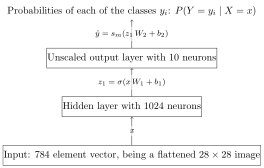

In [4]:
load("Intro\ to\ Machine\ Learning\ with\ Tensorflow.jl/mnist-basic.png")

In [4]:
sess = Session(Graph())
@tf begin
    X = placeholder(Float32, shape=[-1, 28*28])
    Y = placeholder(Float32, shape=[-1, 10])

    W1 = get_variable([28*28, 1024], Float32)
    b1 = get_variable([1024], Float32)
    Z1 = nn.sigmoid(X*W1 + b1)

    W2 = get_variable([1024, 10], Float32)
    b2 = get_variable([10], Float32)
    Z2 = Z1*W2 + b2 # Affine layer on its own, to get the unscaled logits
    Y_probs = nn.softmax(Z2)

    losses = nn.softmax_cross_entropy_with_logits(;logits=Z2, labels=Y) #This loss function takes the unscaled logits
    loss = reduce_mean(losses)
    optimizer = train.minimize(train.AdamOptimizer(), loss)
end


2017-08-02 18:53:18.598588: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-02 18:53:18.598620: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-02 18:53:18.598626: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-08-02 18:53:18.789486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:893] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2017-08-02 18:53:18.789997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:940] Found device 0 with propert

<Tensor Group:1 shape=unknown dtype=Any>

### Train


We use normal minibatch training with Adam.
We do use relatively large minibatches, as that gets best performance advantage on GPU,
by minimizing memory transfers.
A more advanced implementation might do a the batching within Tensorflow,
rather than batching outside tensorflow and invoking it via `run`.

In [5]:
traindata = (flatten_images(MNIST.traintensor()), onehot_encode_labels(MNIST.trainlabels()))
run(sess, global_variables_initializer())


basic_train_loss = Float64[]
@showprogress for epoch in 1:100
    epoch_loss = Float64[]
    for (batch_x, batch_y) in eachbatch(traindata, 1000, (ObsDim.Last(), ObsDim.First()))
        loss_o, _ = run(sess, (loss, optimizer), Dict(X=>batch_x', Y=>batch_y))
        push!(epoch_loss, loss_o)
    end
    push!(basic_train_loss, mean(epoch_loss))
    #println("Epoch $epoch: $(train_loss[end])")
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


In [6]:
plot(basic_train_loss, label="training loss")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 25 
 
 
 50 
 
 
 75 
 
 
 100 
 
 
 0.25 
 
 
 0.50 
 
 
 0.75 
 
 
 1.00 
 
<polyline clip-path="url(#clip02)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,7.87402 44.9535,247.655 50.5369,274.648 56.1203,285.296 61.7037,292.448 67.287,298.371 72.8704,303.631 78.4538,308.366 84.0372,312.632 89.6206,316.482 
 95.204,319.972 100.787,323.148 106.371,326.05 111.954,328.713 117.538,331.164 123.121,333.43 128.704,335.528 134.288,337.477 139.871,339.289 145.455,340.976 
 151.038,342.55 156.621,344.019 162.205,345.393 167.788,346.679 173.372,347.886 178.955,349.018 184.538,350.084 190.122,351.088 195.705,352.034 201.288,352.927 
 206.872,353.771 212.455,354.57 218.039,355.325 223.622,356.042 229.205,356.722 234.789,357.369 240.372,357.985 245.956,358.573 251.539,359.134 257.122,359.669 
 262.706,360.179 268.289,360.663 273.873,361.123 279.456,361.557 285.039,361.967 290.623,362.352 296.206,362.715 301.79,363.056 307.373,363.376 312.956,363.677 
 318.54,363.959 324.123,364.225 329.707,364.475 335.29,364.71 340.873,364.932 346.457,365.142 352.04,365.34 357.623,365.527 363.207,365.704 368.79,365.872 
 374.374,366.03 379.957,366.18 385.54,366.321 391.124,366.455 396.707,366.581 402.291,366.701 407.874,366.814 413.457,366.921 419.041,367.023 424.624,367.119 
 430.208,367.211 435.791,367.299 441.374,367.383 446.958,367.463 452.541,367.539 458.125,367.612 463.708,367.681 469.291,367.745 474.875,367.806 480.458,367.863 
 486.042,367.916 491.625,367.965 497.208,368.01 502.792,368.053 508.375,368.093 513.958,368.13 519.542,368.166 525.125,368.199 530.709,368.231 536.292,368.262 
 541.875,368.291 547.459,368.319 553.042,368.346 558.626,368.372 564.209,368.396 569.792,368.42 575.376,368.442 580.959,368.464 586.543,368.484 592.126,368.504 
 
 "/>
 
 
 
 
 training loss

### Test

In [7]:
testdata_x = flatten_images(MNIST.testtensor())
testdata_y = onehot_encode_labels(MNIST.testlabels())

y_probs_o = run(sess, Y_probs, Dict(X=>testdata_x'))
acc = mean(mapslices(indmax, testdata_y, 2) .== mapslices(indmax, y_probs_o, 2) )

println("Error Rate: $((1-acc)*100)%")

Error Rate: 1.9299999999999984%


## Advanced MNIST classifier

Here we will use more advanced TensorFlow features, like `indmax`,
and also a more advanced network.

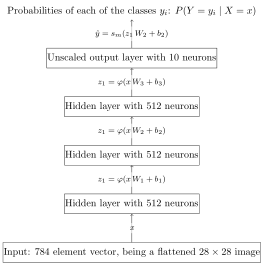

In [5]:
load("Intro\ to\ Machine\ Learning\ with\ Tensorflow.jl/mnist-advanced.png")

In [52]:
sess = Session(Graph())

# Network Definition
begin
    X = placeholder(Float32, shape=[-1, 28*28])
    Y = placeholder(Float32, shape=[-1])
    KeepProb = placeholder(Float32, shape=[])
    
    # Network parameters
    hl_sizes = [512, 512, 512]
    activation_functions = Vector{Function}(size(hl_sizes))
    activation_functions[1:end-1]=z->nn.dropout(nn.relu(z), KeepProb)
    activation_functions[end] = identity #Last function should be idenity as we need the logits

    Zs = [X]
    for (ii,(hlsize, actfun)) in enumerate(zip(hl_sizes, activation_functions))
        Wii = get_variable("W_$ii", [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii", [hlsize], Float32)
        Zii = actfun(Zs[end]*Wii + bii)
        push!(Zs, Zii)
    end
    
    Y_probs = nn.softmax(Zs[end])
    Y_preds = indmax(Y_probs,2)-1 # Minus 1, to offset 1 based indexing

    losses = nn.sparse_softmax_cross_entropy_with_logits(;logits=Zs[end], labels=Y+1) # Plus 1, to offset 1 based indexing 
    #This loss function takes the unscaled logits, and the numerical labels
    loss = reduce_mean(losses)
    optimizer = train.minimize(train.AdamOptimizer(), loss)
end


2017-08-02 19:27:57.180945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:01:00.0)


<Tensor Group:1 shape=unknown dtype=Any>

### Train

In [53]:
traindata_x = flatten_images(MNIST.traintensor())
normer = fit(FeatureNormalizer, traindata_x)
predict!(normer, traindata_x); # perhaps oddly, in current version of MLDataUtils the Normalizer commands to normalize is `predict`

traindata_y = Int.(MNIST.trainlabels());


In [54]:
run(sess, global_variables_initializer())
adv_train_loss = Float64[]
@showprogress for epoch in 1:100
    epoch_loss = Float64[]
    for (batch_x, batch_y) in eachbatch((traindata_x, traindata_y), 1000, ObsDim.Last())
        loss_o, _ = run(sess, (loss, optimizer), Dict(X=>batch_x', Y=>batch_y, KeepProb=>0.5f0))
        push!(epoch_loss, loss_o)
    end
    push!(adv_train_loss, mean(epoch_loss))
    #println("Epoch $epoch: $(train_loss[end])")
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


In [55]:
plot([basic_train_loss, adv_train_loss], label=["basic", "advanced"])

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 25 
 
 
 50 
 
 
 75 
 
 
 100 
 
 
 0.5 
 
 
 1.0 
 
<polyline clip-path="url(#clip02)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,47.3281 44.9535,260.876 50.5369,284.916 56.1203,294.399 61.7037,300.768 67.287,306.044 72.8704,310.728 78.4538,314.945 84.0372,318.744 89.6206,322.174 
 95.204,325.282 100.787,328.11 106.371,330.695 111.954,333.066 117.538,335.249 123.121,337.267 128.704,339.136 134.288,340.871 139.871,342.485 145.455,343.988 
 151.038,345.389 156.621,346.698 162.205,347.922 167.788,349.067 173.372,350.141 178.955,351.15 184.538,352.099 190.122,352.993 195.705,353.836 201.288,354.632 
 206.872,355.383 212.455,356.094 218.039,356.767 223.622,357.405 229.205,358.011 234.789,358.587 240.372,359.136 245.956,359.659 251.539,360.159 257.122,360.636 
 262.706,361.09 268.289,361.521 273.873,361.93 279.456,362.317 285.039,362.682 290.623,363.025 296.206,363.348 301.79,363.652 307.373,363.937 312.956,364.205 
 318.54,364.456 324.123,364.693 329.707,364.916 335.29,365.125 340.873,365.323 346.457,365.51 352.04,365.686 357.623,365.853 363.207,366.01 368.79,366.16 
 374.374,366.301 379.957,366.434 385.54,366.56 391.124,366.679 396.707,366.792 402.291,366.898 407.874,366.999 413.457,367.094 419.041,367.185 424.624,367.271 
 430.208,367.353 435.791,367.431 441.374,367.506 446.958,367.577 452.541,367.645 458.125,367.709 463.708,367.771 469.291,367.828 474.875,367.883 480.458,367.933 
 486.042,367.98 491.625,368.024 497.208,368.064 502.792,368.102 508.375,368.138 513.958,368.171 519.542,368.203 525.125,368.233 530.709,368.261 536.292,368.289 
 541.875,368.315 547.459,368.339 553.042,368.363 558.626,368.386 564.209,368.408 569.792,368.429 575.376,368.449 580.959,368.468 586.543,368.487 592.126,368.504 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,7.87402 44.9535,292.962 50.5369,313.504 56.1203,323.775 61.7037,329.766 67.287,334.976 72.8704,338.456 78.4538,341.24 84.0372,342.693 89.6206,345.277 
 95.204,346.617 100.787,347.864 106.371,349.952 111.954,348.806 117.538,351.698 123.121,351.144 128.704,351.68 134.288,353.022 139.871,353.428 145.455,354.875 
 151.038,355.659 156.621,355.643 162.205,356.292 167.788,357.189 173.372,358.437 178.955,357.461 184.538,354.46 190.122,357.353 195.705,357.619 201.288,358.24 
 206.872,358.385 212.455,358.782 218.039,358.914 223.622,359.116 229.205,359.91 234.789,359.861 240.372,360.151 245.956,359.375 251.539,359.823 257.122,360.956 
 262.706,360.003 268.289,361.29 273.873,361.079 279.456,361.285 285.039,360.97 290.623,361.588 296.206,361.284 301.79,361.694 307.373,360.426 312.956,362.038 
 318.54,362.103 324.123,360.892 329.707,361.191 335.29,360.992 340.873,361.62 346.457,362.145 352.04,361.957 357.623,362.199 363.207,361.542 368.79,362.554 
 374.374,362.236 379.957,362.782 385.54,362.91 391.124,363.274 396.707,361.938 402.291,362.293 407.874,362.045 413.457,362.987 419.041,362.965 424.624,362.474 
 430.208,362.855 435.791,363.227 441.374,362.24 446.958,362.556 452.541,363.099 458.125,362.833 463.708,362.635 469.291,363.005 474.875,362.198 480.458,362.781 
 486.042,362.413 491.625,362.455 497.208,363.585 502.792,363.919 508.375,363.298 513.958,361.991 519.542,362.744 525.125,362.635 530.709,362.617 536.292,362.241 
 541.875,362.714 547.459,362.822 553.042,363.254 558.626,363.462 564.209,364.073 569.792,363.994 575.376,363.412 580.959,363.367 586.543,363.635 592.126,363.718 
 
 "/>
 
 
 
 
 basic 
 
 
 
 advanced

### Test

In [56]:
testdata_x = predict!(normer, flatten_images(MNIST.testtensor()))
testdata_y = Int.(MNIST.testlabels());

y_preds_o = run(sess, Y_preds, Dict(X=>testdata_x', KeepProb=>1.0f0))
acc = mean(testdata_y .== y_preds_o )

println("Error Rate: $((1-acc)*100)%")

Error Rate: 1.770000000000005%


It can be seen that overall all the extra stuff done in the advanced model did not gain much.
The margin is small enough that it can be attributed to in part to luck -- repeating it can do better or worse depending on the random initialisations.
Classifying MNIST is perhaps too simpler problem for deep techneques to pay off.


# Bottle-knecking Autoencoder

An autoencoder is a neural network designed to recreate its inputs.
There are many varieties, include RBMs, DBNs, SDAs, mSDAs, VAEs.
This is one of the simplest being based on just a feedforward neural network.

The network narrows into to a very small central layer -- in this case just 2 neurons,
before exampanding back to the full size.
It is sometimes called a Hour-glass, or Wine-glass autoencoder to describe this shape.


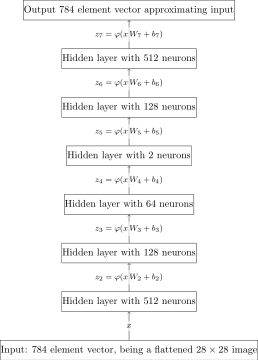

In [6]:
load("Intro\ to\ Machine\ Learning\ with\ Tensorflow.jl/autoencoder.png")

In [7]:
sess = Session(Graph())

# Network Definition

begin
    X = placeholder(Float32, shape=[-1, 28*28])
    
    # Network parameters
    hl_sizes = [512, 128, 64, 2, 64, 128, 512, 28*28]
    activation_functions = Vector{Function}(size(hl_sizes))
    activation_functions[1:end-1] = x -> 0.01x + nn.relu6(x)
        # Neither sigmoid, nor relu work anywhere near as well here
        # relu6 works sometimes, but the hidden neurons die too often
        # So we define a leaky ReLU6 as above
    activation_functions[end] = nn.sigmoid #Between 0 and 1


    Zs = [X]
    for (ii,(hlsize, actfun)) in enumerate(zip(hl_sizes, activation_functions))
        Wii = get_variable("W_$ii", [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii", [hlsize], Float32)
        Zii = actfun(Zs[end]*Wii + bii)
        push!(Zs, Zii)
    end
    
    
    Z_code = Zs[end÷2 + 1] # A name for the coding layer
    has_died = reduce_any(reduce_all(Z_code.==0f0, axis=2))
    
    losses = 0.5(Zs[end]-X)^2
    
    loss = reduce_mean(losses)
    optimizer = train.minimize(train.AdamOptimizer(), loss)
end

2017-08-02 19:52:56.573001: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-02 19:52:56.573045: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-02 19:52:56.573054: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-08-02 19:52:56.810042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:893] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2017-08-02 19:52:56.810561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:940] Found device 0 with propert

<Tensor Group:1 shape=unknown dtype=Any>

The choice of activation function here, is (as mentioned in the comments) a bit special.
On this particular problem, as a deep network, sigmoid was not going well presumably because of the exploding/vanishing gradient issue that normally cases it to not work out (though I did not check).

Switching to ReLU did not help, though I now suspect I didn't give it enough tries.
ReLU6 worked great the first few tries, but coming back to it later,
and I found I couldn't get it to train because one or both of the hidden units would die,
which I did see the first times I trained it but not as commonly.

The trick to make this never happen was to allow the units to turn themselves back on.
This is done by providing a non-zero gradient for the off-states.
A leaky RELU6 unit.
Mathematically it is given by 
$$\varphi(z)=\begin{cases}
0.01z+6 && 6<z \\
1.01z && 0 \le z \le 6 \\
0.01z && z < 0
\end{cases}$$

## Training

In [8]:
train_images = flatten_images(MNIST.traintensor())
test_images = flatten_images(MNIST.testtensor());

In [9]:
run(sess, global_variables_initializer())
auto_loss = Float64[]
@showprogress for epoch in 1:75
    epoch_loss = Float64[]
    for batch_x in eachbatch(train_images, 1_000, ObsDim.Last())
        loss_o, _ = run(sess, (loss, optimizer), Dict(X=>batch_x'))
        push!(epoch_loss, loss_o)
    end
    push!(auto_loss, mean(epoch_loss))
    #println("Epoch $epoch loss: $(auto_loss[end])")
    
    ### Check to see if it died
    if run(sess, has_died, Dict(X=>train_images'))
        error("Neuron in hidden layer has died, must reinitialize.")
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


In [10]:
plot([auto_loss], label="Autoencoder Loss")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 0.02 
 
 
 0.04 
 
 
 0.06 
 
<polyline clip-path="url(#clip02)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,7.87402 46.8398,260.674 54.3094,267.93 61.7791,271.81 69.2488,278.343 76.7185,282.005 84.1881,283.083 91.6578,283.617 99.1275,283.94 106.597,284.222 
 114.067,284.557 121.536,285.107 129.006,285.72 136.476,286.461 143.946,287.535 151.415,289.475 158.885,292.618 166.355,294.952 173.824,298.302 181.294,301.181 
 188.764,303.369 196.233,304.02 203.703,305.49 211.173,306.592 218.642,307.361 226.112,308.952 233.582,312.38 241.051,317.447 248.521,323.025 255.991,328.188 
 263.46,331.822 270.93,335.591 278.4,338.634 285.869,341.112 293.339,343.369 300.809,345.181 308.278,347.111 315.748,348.239 323.218,349.581 330.687,350.755 
 338.157,351.971 345.627,352.766 353.096,353.626 360.566,354.283 368.036,355.516 375.505,356.279 382.975,356.746 390.445,357.561 397.914,357.959 405.384,358.751 
 412.854,358.626 420.323,359.476 427.793,360.082 435.263,360.375 442.732,361.444 450.202,362.048 457.672,362.451 465.142,362.909 472.611,363.413 480.081,363.777 
 487.551,363.982 495.02,364.536 502.49,364.912 509.96,365.33 517.429,365.378 524.899,365.639 532.369,365.885 539.838,366.026 547.308,365.797 554.778,366.892 
 562.247,367.144 569.717,367.655 577.187,368.09 584.656,368.273 592.126,368.504 
 "/>
 
 
 
 
 Autoencoder Loss

In [11]:
function reconstruct(img::Vector)
    run(sess, Zs[end], Dict(X=>reshape(img, (1,28*28))))[:]
end

reconstruct (generic function with 1 method)

In [12]:
id = 120
heatmap([one_image(train_images[:,id]) one_image(reconstruct(train_images[:,id]))])

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
<image width="493" height="361" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAAe0AAAFpCAYAAACxlXA1AAATMUlEQVR4nO3daZSeZXkH8Ot9ZyaZ
hBBCFgiE1UR20KAQNaGIgqAoiHJEBYVaUeqpSlvRVmyPe1ftOa3KQWjdi0sVw1LQoiyKyNa4EBYJ
2BBCCBAI2SaTWd5+8Zyeeuz1JJ2ZMBf5/b7+n7mfa9b/ub9c04ro7gQAMO61n+kBAICto7QBoAil
DQBFKG0AKEJpA0ARShsAilDaAFCE0gaAIpQ2ABShtAGgCKUNAEUobQAoontrHhrsfHGMxwC2VXfr
nBF9vN9rGH+afq/dtAGgCKUNAEUobQAoQmkDQBFKGwCKUNoAUITSBoAilDYAFKG0AaAIpQ0ARSht
AChCaQNAEUobAIpQ2gBQhNIGgCKUNgAUobQBoAilDQBFKG0AKEJpA0ARShsAilDaAFCE0gaAIrqf
6QEA2AF0tuKZ1hi/Y6TnjwNu2gBQhNIGgCKUNgAUobQBoAilDQBFKG0AKEJpA0ARShsAilDaAFCE
0gaAIpQ2ABRh9zhQ29bstB6J7bGvupN/EkNDmxryzWnebvc0jtDdPTV/oOnr0PB96MRQ4wwx3DBC
q6v5jGyG4XyGVntk528PbtoAUITSBoAilDYAFKG0AaAIpQ0ARShtAChCaQNAEUobAIpQ2gBQhNIG
gCKUNgAUYfc42+SBUz6f5gde+ZPGMw7a6ZQ0/9mHrtummX5b95yB/IG3XDKi8xlnRrobvGl3+Vjv
No+ITsPS7eHh/Gd66MmfpfmE71/WOMPTP90nzR9dPifNu7sH03zarCcbZ5hx7ANpvmXBS9N8cM6L
0nzS5P3yARp2wEdERGt7LKP/v7lpA0ARShsAilDaAFCE0gaAIpQ2ABShtAGgCKUNAEUobQAoQmkD
QBFKGwCKUNoAUITd4/wvm5dfkeafvvX5ad5q3dr4jvs2XZ3mkz7YeERqzk4L0/z+h/6o8YyeCz8z
siGoY6x3l0fzbvGhwQ15vvKHad79tevT/JrvnpbmERFXrpiV5g9s2JLmG6I/zffumdI4w7E/XpTm
r3nekjSfc/bFaT5w/J+l+YQJM9I8Ipq/32O8mtxNGwCKUNoAUITSBoAilDYAFKG0AaAIpQ0ARSht
AChCaQNAEUobAIpQ2gBQhNIGgCLsHn+WGRx4Os1vXHRjmn/yrl3S/Ka+fLfveLBy481pfsPi1zae
ccKFozUN5TXsmu50BhqP6O9/LM27l/5bmq/6+MQ0v+j2t6T5krX5XvCIiLWxJs3Xt9en+bpO/jmu
GOptnOGRh+em+erNC9L89we70nz2gdflA8w9I88jxny3eBM3bQAoQmkDQBFKGwCKUNoAUITSBoAi
lDYAFKG0AaAIpQ0ARShtAChCaQNAEUobAIqwe7yQTRseaHzmqpf8Os3PvGvxaI1T1k9Xz2p85pjl
V6R5776njNY4jLWG3eFNDwwPb0nzzZseahxh0m1fSfMbLjwyzT979+w0v3/40TSfHJPTPCKiq6EO
pg5PTfOdYkqar2utbZxhVXtVmt/8xN5pvsfSI9L83Gu+lOaD570qzSMiunt2bnxmLLlpA0ARShsA
ilDaAFCE0gaAIpQ2ABShtAGgCKUNAEUobQAoQmkDQBFKGwCKUNoAUITd44Vcf+x9jc+cede3t8Mk
tX10xSWNz3zwmz35AxfYPT5ujHi3eH+ab27Y+T/p9q83DRCL37cozT91f/7z9nD73jTftZPv058Q
XWkeEXHg5J3S/KgZm9O83cq/zj9/ambjDDevfyLNl7dXpPl1jz4nzU+6YX6az3rjL9I8IqJ71sLG
Z8aSmzYAFKG0AaAIpQ0ARShtAChCaQNAEUobAIpQ2gBQhNIGgCKUNgAUobQBoAilDQBF2D0+ioaH
8h3GG87/RJqf+i8vS/Nb+v9jm2caj9qt3jSf2rt/mq/vz/cPDw1v2OaZqCzfeT00lO/M7m/cLX5Z
mi++4PfSPCLir+/P70fLW0vTfNfYM8337Zqe5q/ccyDNIyJeccgdaT59zuo037hmWprvfu9BjTM8
+esZaX7D4ENpfv/Q42m+fFX+ddxjTf6zEBERdo8DAFtDaQNAEUobAIpQ2gBQhNIGgCKUNgAUobQB
oAilDQBFKG0AKEJpA0ARShsAirB7fBQ17Raf8dmVDSd8ZfSG+X9607R3pvllay8e8TuO6T0jza/b
mO9yfs/s29L8osdGPiPjRL5W/DeP5A/1b85/7ybd+rU0v+nDR6f5P90/Kc0jIpa3fpbmva2pab6w
d+80P2te/jkedcxP0zwiYvKifD95p6srzXe6O99Nvt8T+X70iIhpK/Pd463B/J65rvVkmj+6YU6a
d61dlubjgZs2ABShtAGgCKUNAEUobQAoQmkDQBFKGwCKUNoAUITSBoAilDYAFKG0AaAIpQ0ARdg9
vpWeftdHGp+Z96V8f3BE0+7xsfepuW9L8/OuuDvND3rV29N81sR8f3FExBknXNfwRL57nB1HJ4ab
nxnekuYTln0/zR++dM80/+zde6T5/e1fpnlERLvTk+aLeg5J8z95wdI0P/DUm9O8c+TBaR4R0bfX
YfkDnaE0njg9/zrseV/z37/p9x6U5lM3zkzzwVbDz0I7/xxaw3k+HrhpA0ARShsAilDaAFCE0gaA
IpQ2ABShtAGgCKUNAEUobQAoQmkDQBFKGwCKUNoAUITd478x9Hfnpfn+X9in8Yz1/feM1ji/U98n
JzY+0144J803H9yV5hNmnpPm59/643yAnqb96xGTd/1o4zMQEdFp2HcdEbF5zZ1p3nNl/nt50S1n
pfnSoXxndlcr3yseEXFU+/A0//Oj893iB7/rF2m+Zd7CNB/cvWGveER0Tc7/dnQaPn5Lw97unZ9z
beMMs3vz3eGzOtPTfF1nY5rPmJzng9N2T/OIiJ5Ovg+/1Rrbu7CbNgAUobQBoAilDQBFKG0AKEJp
A0ARShsAilDaAFCE0gaAIpQ2ABShtAGgCKUNAEXsMLvHBweeTvPvfOX0NF/ff9mIZ5i704lpft7u
+e7fodMfbnxH97wz0nxy4wm5ybstGuEJ8D86w4NpvnnTQ41nTFpyVZpf+Z2T0/yWpzan+VA7n3FB
18FpHhFx/uH553HIu+9O8/4Djk7zoV3y/43QmrRbmkdEtLsmpXmnM5DPMGFK/oLh5jti31D+vxG6
Gjag7981I83n7XdLmg9NeW6aR0Q0b5ofW27aAFCE0gaAIpQ2ABShtAGgCKUNAEUobQAoQmkDQBFK
GwCKUNoAUITSBoAilDYAFLHD7B6/cdGNaX7mXYtH/I5JPXuk+d0f+36at8+/dMQzPBts+fD5aX7F
xiNGdP57Z7+z8ZnBU5eleb4hma01NNSX5l2P3t54xvKL907zLz84Lc03xto0PyD2SvNzD1yd5hER
L3pP/ven7wWvT/PW1Hlp3t3Vm+ZdXTul+dYYGGj4Xq1dkea/vuV5je/45dq8kjqR7z8/fForzXd/
8dI03zzl2DQfD9y0AaAIpQ0ARShtAChCaQNAEUobAIpQ2gBQhNIGgCKUNgAUobQBoAilDQBFKG0A
KOJZs3v89mO/nuYn33nLmM9wVPcJad4+f/zvtd0e+jYtT/MfXvmKNF+58dsjev+JezXvip54wJtH
9A62zpZ196X55Dtvajzj4tvOTvMHhh5P82mxc5q/bu8taf7SM65K84iIvoWnp/mEWS9K81Yr/1Pd
inzndjTmEc

In [13]:
id = 1
heatmap([one_image(test_images[:,id]) one_image(reconstruct(test_images[:,id]))])

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
<image width="493" height="361" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAAe0AAAFpCAYAAACxlXA1AAARGElEQVR4nO3dWYxe5X0G8Pd83zff
LLaxjc1qtrDZNQECtAkSaZOQBim0RG1aShKFhhKUlCYoShtVSFRRlULTNmoviERUQtJ0i6LCFRWh
aakQBImyGJoEg1nMbhZjDHgZz/qdXlBVykX/71gz2PO3f7/b53znvDPj4eHcPNOU0msLALDodfb3
AQCAuVHaAJCE0gaAJJQ2ACShtAEgCaUNAEkobQBIQmkDQBJKGwCSUNoAkITSBoAklDYAJNGby0Uz
7ffe4WMAe6vXXDavz/u9hsWn9nvtTRsAklDaAJCE0gaAJJQ2ACShtAEgCaUNAEkobQBIQmkDQBJK
GwCSUNoAkITSBoAklDYAJKG0ASAJpQ0ASShtAEhCaQNAEkobAJJQ2gCQhNIGgCSUNgAkobQBIAml
DQBJKG0ASEJpA0ASShsAklDaAJCE0gaAJJQ2ACShtAEgCaUNAEkobQBIQmkDQBJKGwCSUNoAkITS
BoAklDYAJKG0ASAJpQ0ASShtAEhCaQNAEkobAJJQ2gCQhNIGgCSUNgAkobQBIAmlDQBJKG0ASKK3
vw8A8P9q53BN846fglLm8LOoXbAAPyg/a2/aAJCF0gaAJJQ2ACShtAEgCaUNAEkobQBIQmkDQBJK
GwCSUNoAkITSBoAklDYAJGF7HNh/5rItPt97ZNirrnwNbRmEebMA719tOxvmg8FEmM/O7p7X/Usp
pddbHuad7nCY178P++Afwzv8CG/aAJCE0gaAJJQ2ACShtAEgCaUNAEkobQBIQmkDQBJKGwCSUNoA
kITSBoAklDYAJGF7HFi02lLfqx4MpsK80wxV7hCPRU9MvBh/fPujlfuX0kzHu93NTJx3JnfF+fjO
ON+1I8xLKaUdGYnz0WXxM5r4+zgYHqueYWrVSWHeXb4uzHtDK8K8abqVE9SHwxfiivnwpg0ASSht
AEhCaQNAEkobAJJQ2gCQhNIGgCSUNgAkobQBIAmlDQBJKG0ASEJpA0ASB832+I4v/mmY/+EPLgzz
9Stmqs9Y1ouv+ewX/yG+wZnvCuPOL19TPQMsJu0g/p2YnY03tacmXq0+o/PaI2E+9Orm+PPbXwvz
kZfeCPOZ14bDvJRSxl84Isy3bYnznbuXhvmOPavCfHKmtr9eynBvOsz73fhn2TRtmK9cFu+jl1LK
u869OX7GR+Nt8qnTLg7zfj/+PjWd+vdpf7/retMGgCSUNgAkobQBIAmlDQBJKG0ASEJpA0ASShsA
klDaAJCE0gaAJJQ2ACShtAEgiYNme/wX/35dmD+z61vxDV6f/xn+4Ko4H+3vCfPzh++d/yEOAO9e
Hv+/5rV/flN8g0u/vYCnITI7mAjz2rZ4/6k7qs/o3vdwmO969Ogwf+XpU8N88yvx5ze9uSLMSynl
kTfjTevHxuNd7h2dOB+UQZgf2i4J81JKWdUZDfNe04T59tnJ+Ay946tnuGBz/LP4vRJvk7dHPBTm
s0e8P8x7zRwqcT+/6nrTBoAklDYAJKG0ASAJpQ0ASShtAEhCaQNAEkobAJJQ2gCQhNIGgCSUNgAk
obQBIImDZnv80WvujvM7zg/zde/fUH3GpnvOCfMfbj45zG/YtjHMb9t5Y/UMxy79QJi/sOuu6j3m
o9MZqV6zevSMMN+6+/4wvy2eYS5nfuNTYX7xpfHnmbt2MBvmg8oedfPmk2Hee/6p6hl2bToyzDdv
jPesN7x0bJg/8Hq8yf3Y7t1hXkopz3YeC/OpTvx3B8aaeN98zeCYMD+uPxbmpZRy1GhlW3wq/vzm
ifgXc/vsW9UzLH0t/lle8vLqMB+pnGF2djzMe0OHhPli4E0bAJJQ2gCQhNIGgCSUNgAkobQBIAml
DQBJKG0ASEJpA0ASShsAklDaAJCE0gaAJA6a7fHe1TeE+RlX1+5QH6yOF7Xr+ZdejjeMh/6xvn8+
dfm6MO/fFO96z1fnkMpAcSll6sJ4X3jN+rVhvmPP42H+nuOerZ6BfWUwr0+3w8PVa7rD02E+Ohzv
n88M4neXeJG7lFXd+t7+Md3Tw3zNWPyUdYfE2+SnrHw9zFcseSHMSyllpPJ9uu/Zk8L8qWeWhPnm
Tvx7W0opU4Mjwnx4Zbwt3g7FO/H9/qowbxK8xy7+EwIApRSlDQBpKG0ASEJpA0ASShsAklDaAJCE
0gaAJJQ2ACShtAEgCaUNAEkobQBI4qDZHs9g9KhfjS/440pe5vADvfrcOZ/nnTJ11VfDfMfEljA/
d+x3w/yYv403lFk4bZkN804n3g6fOeTEOD/21eoZRs95KMyPHTwZ5qfvWB7mI93VYb50qL63f/Lq
rWF+4mlPxM8446Uwb45aEeZtv76PXl54JYxfvPGwMJ8oY2E+NYj/tkIppawZjTfYR9bH2+PjS+O/
a9B0huID1IbmFwFv2gCQhNIGgCSUNgAkobQBIAmlDQBJKG0ASEJpA0ASShsAklDaAJCE0gaAJJQ2
ACRhe5wFNfn0LdVrTv5uZSe5fT7Mb7v8zjAfXfO16hlYGJ1Of16f74+tCfOpI8+o3qPtxnvSY3vu
DvNTtm0O8xUvx3vXRx//YpiXUsryc54L83Z9vME+eezHKk9ow7S3vX7GzsZ4e/yx7avC/IlB/H1e
1juieoZLTo1/FjPr438PzdjRcd7kf0/N/xUAwEFCaQNAEkobAJJQ2gCQhNIGgCSUNgAkobQBIAml
DQBJKG0ASEJpA0ASShsAkrA9zoK655P1Leo3xn8W5stGTgrzQy54Y6/OxP7TaeJd8NKtfL6yJV1K
KTNHDsePWPdamK/Y8kyYj618K8xHjtkW5qWU0hy+NL5geiqM+y9ujO8/ORHnr74aP7+U8uQd7wvz
u7bGv9szg/Ew/+BQfUf+7N+5McwnD//tMO/3V1efkZ03bQBIQmkDQBJKGwCSUNoAkITSBoAklDYA
JKG0ASAJpQ0ASShtAEhCaQNAEkobAJKwPc5eGdxwRZhf+GC8Az0Xr3/9ufiCi26a9zNYHJrKe0O/
v6p6j9nuaJhPrfmFMB89fUuY97ZsDfO2DeO3r9m6K75gW5w3tderJo7fvP+4yg1KuWXju8P8p7Mv
hPnK/glhftXpT1fP0J69Ls5XrA3zTqf+tw+y86YNAEkobQBIQmkDQBJKGwCSUNoAkITSBoAklDYA
JKG0ASAJpQ0ASShtAEhCaQNAErbH2Sv/9p2Ph/lgcHP1Hp8+9Mown7nypDA/8NeFDyKVUe2mDFVv
0e0uCfPZVWeG+eT63WHeH/1JmHe2vxHmpZTS7pwM86ZfGQ9fFn+N7fZ4u3zTI/Gmdyml/GhrfMZd
ndfD/ENDZ4X5OZ+4sXqGyRM/E+bDI0fFN6iOtOd34H+FAHCAUNoAkITSBoAklDYAJKG0ASAJpQ0A
SShtAEhCaQNAEkobAJJQ2gCQhNIGgCRsj/NzxndtDvO/2bQ0zDvdOC+llO9eF28QN8M3Ve9BDm1p
53eDyiR3KaU0TfyfsX5/dZhPHHZamE92umHeO/SlMC+llGZyPMzb4bE47w+Heec/Hgjzf9l8QpiX
Usqm5t4wX9UeG+ZXrHsxzKcvuKB6hqGV8X55txN/H+b0DyY5b9oAkITSBoAklDYAJKG0ASAJpQ0A
SShtAEhCaQNAEkobAJJQ2gCQhNIGgCSUNgAkYXucn/PAR34a5neN3xrmVxx2ZfUZze+/d6/ORF5N
E78XtO0g/v

## Visualising similarity 
One of the key uses of an autoencoder such as this is to project from a the high dimentional space of the inputs, to the low dimentional space of the code layer.

In [14]:
function scatter_image(images, res)
    canvas = ones(res, res)
    
    codes = run(sess, Z_code, Dict(X=>images'))
    codes = (codes .- minimum(codes))./(maximum(codes)-minimum(codes))
    @assert(minimum(codes) >= 0.0)
    @assert(maximum(codes) <= 1.0)
    
    function target_area(code)
        central_res = res-frames_image_res-1
        border_offset = frames_image_res/2 + 1
        x,y = code*central_res + border_offset
        
        get_pos(v) = round(Int, v-frames_image_res/2)
        x_min = get_pos(x)
        x_max = x_min + frames_image_res-1
        y_min =  get_pos(y)
        y_max = y_min + frames_image_res-1
        
        @view canvas[x_min:x_max, y_min:y_max]
    end
    
    for ii in 1:size(codes, 1)
        code = codes[ii,:]
        img = images[:,ii]
        area = target_area(code)        
        any(area.<1) && continue # Don't draw over anything
        area[:] = one_image(img)
    end
    canvas
end
heatmap(scatter_image(test_images, 700))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
<image width="493" height="361" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAAe0AAAFpCAYAAACxlXA1AAAgAElEQVR4nOzdZ2AUVdfA8f/sZlM2
IQHpvVdBivQiHUEEFEFAuqFjo8gjoryIKIooFqSDVCmKgAoiIEV6qErvvRNI3U3dfT9EAlEgbWZn
dnN+n3Y3M/ccY9gz986de5UE50InQgghhDA8k94JCCGEECJtvPROQAghREpeSi/V20xwzlW9TfFw
XkovzX7fUrSFEMKA3KnIykWG60jRFkIIkWlqFlktLgKMrnS2RVQxlWR297UETh7zyOPknrYQQngI
u+0Cn5bYidV7BGEDxuqdjkijHk+EcMH2JysjZ1J8ju9jj5WethBCeIiggHEAxEx2Yho0QedsHs9+
fTMvlbKwPnoWuxs1p9qmVzSPqeW95oxyTO7DknBz8vvI2HOPPV6KthBCuDlb+GEaFbgCQDbfkpgG
vaNzRqkLzD8v+XWE3apjJvoJeWYp9bY5UZT7n5WyNn/sOTI8LoQQbu6JnDM5aP+REQX7cCW0u97p
pOrbMtuSX9v3V6fRrhfUDbCgLzPK/YnTkaBuuyqq77+R+ts3pvhsbY127LtR47HnSU9bCCHcUPyR
2TSpWYJd9oUo//S/xl2qpXNWqRuYJ4RZt2YDsLV+K7yqvqxa2/brm5lc15t3zyXgZA6BlePpfKip
au2r5VbPCey2nwDA6UwEII+1Ok13t031XCnaQgjhRuy2C/jM+RD/NxRgFwCxv+VCeXa8vomlwQdF
dzHr1nQAzr9chYJL1SvYtqgzBD0w5P5KjkG8EFJQtfbVMqJgCF9eP4Oi3C+/XXP0Z8qxuDSdL0Vb
CCHchHNGH4IGKEDSTdC+ufvy7Y2a+ib1L47t46H2UExmn+TPwgd9QJE5DmyxF7FYctP3iQ4UXKpe
3omT+lH0vTIpPpt2MSe+fsYq2omf92fStYQUBRtgbmjafxdStIUQwg2MKBjCl9cUFJMv88q/YMhh
XwBTvZEp3ttubiPX1PPJ71/O1oHPNh0F1CnaiZ/3x3d4PHAEgPeK9Of/LtRWpW21xJ78nspPe3HW
lvLzn6u2peXe1ulqS4q2EEIYnGPTGL68ljQ7PNo+Di9LkM4Zpc529yArG9yh/6kNAJjNgeT2q/BP
r1Kdgv1ZiR28e+7+sPLp9tWJjDxBuWwX+etWQ3x886oSJ7PMxVuzot5PvLm1G5vscwGI/TU7Sqv0
FWyQoi2EEIZnskUD8HO1F9yiYMe+N5Qc42NxOJK6li38+7Ks32r8v+ivWoyECQN591xMis/+OFqR
znsKcTygpGpx1OBlCaL82t6sA6BB5tpSIyEhhBAaav0ZcQ69k0g770IRoPjR2PoqKweuwTqxLlBX
lbZj7FcYUOgKi+7cL9g9cg5k1sczUPo1VCWGkUnRFkIIoSplwCxiB9x7l7me5b+tqHmchXcWJMVB
oba1B7Nvqzfkrha110+/t5KbFG0hhDAgrb70PYHyz+z5T0v2ZcAO4w1BaPm7lqIthBAG444F1lU7
c7XbHETTIsHsSvyDoafVGXJ3J0qCc6FT7ySEEEIIrblqwxAt48ja40IIIYSbkOFxIYTQkRbDyq4e
Xle7Z6lVT9Wotx2Sdvtah9OZiP1wAyxPBj/yWCnaQgihM6MWE+Ea9bdtSNr0RYHfuhWk7YFHHyvD
40IIIXTxbZltbKmzQu80dHWo+fwU71stvPLY46VoCyGEG3LO6cPqp9fgpfSiQ+AuQl81/i5fD/qy
1HbeOv0d350siO3mttRP8EA/PLWean9sSX5/+ZXyjx0aBxkeF0IItxPx+mhyfusElqMoZn6MqA0Y
a5OM1Iw4l9TDnNJ7BdY87nXBoYYd9X+k6+HfU3yWd+HwVM+Toi2EEG7C+V0fvF9NBMVENp+SjCvc
gAFvzUv9RAO5t+MVQIfAflgn1tI5I3003PEbAE5nIigwrlifNJ0nRVsIIdxAkWyzuBZ9f1mNW5Fv
YvbyR+1lQrU2qG4pztpmU93nZYZWPgdkvaLdKWh30sQzAAVu9StK9ml10nSuFG0hhDC4b0pv41r0
TgB2N2pOlXYbMXn565xV+jkm92H+naQLjx02Y+4HrrWuOXazInJWis+yTxud5vOlaAshhEGFDRhL
7unnkt8XC2hGtU2vAK/ol1QGbK69khZ7fgPMlPZvztHIDnqnpIvY0UNYFh6R3Mtu5NeDleeUdLUh
s8eFEMKgSs33BcUEiokhBQZyKrKr3imly8UOk+kUtPufgp0kqxZs54w+ZBsXlfy+jt8rrItugDVP
/XS1Iz1tIYQwohVvEh5z/0t+whVjbT2ZGvv1zdT73cL16BkE+Zbl+phzeI2YqndaulH6zSKuX+bb
kaIthBAG45jSB5/X7k86u/ByJR2zST/b3YOMfdrKDdt+AG7bRuickeeQoi2EEAZW3L85ear8qXca
6eJzehNfXD+udxoeSYq2EEIYVPQYf7yansNUb4reqaSLucYQ4hL1zkI/Wq4lL0VbCCEMxjRoFvGD
9M5CGJGS4FzoTP0wIYQQWvCErTmF60jRFkIIIdyEDI8LIYSLaNGrBulZZyVStIUQwoXULrBaXQgI
Y5IV0YQQQiNSUIXapGgLIYTB2W0XsJiCsZiCsd3epXc6QkcyPC6EEAbm+LoPQUPMWL0LsbBCbay5
auudktCR9LSFEEIFFbL9mNQTvntQtTZ7PBGC7xAzTmcCN/8uS5v9rVRrW7gn6WkLIUQGxdivMKL4
FabenE70GH+8R89Wre3YmBusjtnIE77luTbpMEoZ99qOMyvT8tl7KdpCCJFBAdZRKCi8nH0A3qNr
qdbu1ro/0WTXauwf++D1jnstYSqSaPUYngyPCyFEBliU3tSx9iRmgg+L7qpTsJ3rR9HQfxNNdq3m
0xLBUrDFf0hPWwgh0mhz7ZVsvZaPsZdm4sTJ1ujGQGNV2p5R7k8Gn7wOLCQ2fgoms48q7QrjS5zU
D5+hcSiKmf8V7Me4S4++CJSethBCpNGze37nbJSJ8NDXVR3+tEWcYPDJeQAcbllXCnYW4zfMiaKY
UTAx4cqsxx4rPW0hhEiFY/t4xnRpwjelu9DveE1V204YP5jCHxbmab/O7JrxIwkvd1C1fU/jaRus
xI4ekvw6m29Jbn18+rHHS9EWQohUjO7chE+vzCA89HXV257xXWciYuYSbS1HYplymEy+qsfwJJ62
DGyXL18G5gAQnKMJprfeeezxMjwuhBCPYTEFExanEB76OtYcVVRvf9DJBsQ7ZnMo6gXMNYbI0HgW
0jXHbn6NmpP8/uOfU1/tToq2EEI8gkXpzcVOFZl8o6YmBdvo9O6FquFAk0V4Kb1I3DNJ71RSGF4g
hGXhM5Lff1oiGK+n30j1PBkeF0KIR4h3fqd6m55QCN1Jzc0bURSz3mmk4Pztf3x9/U6Kz956bQ5Q
N9VzpWgLIYSLGHHf60oBKzkevYqIy53wK9hS73RUExcbynslztx/X6gSfjrm86AqHesBvyS/j3PM
TPO5UrSFEEIjRizSD0r8vD8XE/JhseQGs2dNgKuRcztHbasAyG2thl/+ZjpnlMTb1DfF+wF5+j7i
yIeTe9pCCJEF2e4exHd4HLbYi9w5WQe/fI30TkkVzt9HUjXg1+SCDXD1u2M6ZvRoxf2bM3HLiXSd
Iz1tIYTIYuLGvEWhT/MAMLpIf3yLecZ2n8srr6PzoZvAiuTP4lcFQZsv9EvqEQ61rE3ZNZ3TfZ4U
bSGE

In [15]:
heatmap(scatter_image(test_images, 4_000))
savefig("mnist_scatter.pdf")

A high-resolution PDF with more numbers shown can be downloaded from [here](http://white.ucc.asn.au/images/mnist_scatter.pdf")

So the position of each digit shown on the scatter-plot is given by the level of activation of the coding layer neurons.
Which are basically a compressed repressentation of the image.

We can see not only are the images roughly grouped acording to their number,
they are also positioned accoridng to appeance.
In the top-right it can be seen arrayed are all the ones.
With there posistion (seemingly) determined by the slant.
Other numbers with similarly slanted potions are positioned near them.
The implict repressentation found using the autoencoder unviels hidden properties of the images.

# Conclusion

We have presented a few fairly basic neural network models.
Hopefully, the techneques shown encourage you to experiment further with machine learning with Julia, and TensorFlow.jl.
